# 1 - Imports

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pycorrcat.pycorrcat import corr_matrix
from warnings import filterwarnings

In [4]:
filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option( 'display.expand_frame_repr', False )

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [18, 8]

sns.set;

## 1.1 - Funções

In [5]:
def kde(var):
    '''Função para a seção 5.1.3 - Análise univariada da variável categórica'''
    aux = df5.sort_values(var)
    aux = aux[var].unique()
    for e in aux:
        sns.kdeplot(df5[df5[var] == e]['response'], label=e, shade=True)
        plt.ticklabel_format(style='plain', axis='y')

## 1.2 - Cargando os dados

In [6]:
df = pd.read_csv('../data/train.csv')

In [7]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 2 - Descrição dos dados

In [8]:
df2 = df.copy()

## 2.1 - Dimensão do dataset

In [9]:
print(f'Quantidade de linhas: {df2.shape[0]}')
print(f'Quantidade de colunas: {df2.shape[1]}')

Quantidade de linhas: 381109
Quantidade de colunas: 12


## 2.2 - Renomear as colunas

In [10]:
new_columns = []
for e in df2.columns:
    new_columns.append(e.lower())

df2.columns = new_columns

## 2.3 - Tipos dos dados

In [11]:
df2.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 2.4 - Dados nulos

In [12]:
df2.isnull().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## <font color=red> 2.5 - Correção dados nulos (não necessário) </font>

## <font color=red>2.6 - Alteração dos tipos dos dados (não necessário)</font>

## 2.7 - Análise descritiva

In [13]:
num = df2.select_dtypes(include=['int64', 'float64'])
cat = df2.select_dtypes(exclude=['int64', 'float64'])

### 2.7.1 - Análise numérica

In [14]:
# média, desvio padrão, mínimo, quartis, máximo
desc = num.describe().T
desc.drop('count', axis=1, inplace=True)

# mediana
median = pd.DataFrame(num.apply(np.median))
desc.insert(2,'median', median[0].values)

# range
range_ = pd.DataFrame( num.apply( lambda x: x.max() - x.min() ) )
desc.insert(len(desc.columns),'range', range_[0].values)

# trocando o desvio padrão de posição
std = desc.pop('std')
desc.insert(len(desc.columns),'std', std)

# skewness
skew = pd.DataFrame(num.apply(lambda x: x.skew()))
desc.insert(len(desc.columns),'skew', skew[0].values)

# kurtosis
kurtosis = pd.DataFrame(num.apply(lambda x: x.kurtosis()))
desc.insert(len(desc.columns),'kurtosis', kurtosis[0].values)

# Remover 25%, 50% e 75%
desc.drop(['25%', '50%', '75%'], axis=1, inplace=True)

desc

,mean,median,min,max,range,std,skew,kurtosis
id,190555.000000,190555.0,1.0,381109.0,381108.0,110016.836208,9.443274e-16,-1.200000
age,38.822584,36.0,20.0,85.0,65.0,15.511611,6.725390e-01,-0.565655
driving_license,0.997869,1.0,0.0,1.0,1.0,0.046110,-2.159518e+01,464.354302
region_code,26.388807,28.0,0.0,52.0,52.0,13.229888,-1.152664e-01,-0.867857
previously_insured,0.458210,0.0,0.0,1.0,1.0,0.498251,1.677471e-01,-1.971871
annual_premium,30564.389581,31669.0,2630.0,540165.0,537535.0,17213.155057,1.766087e+00,34.004569
policy_sales_channel,112.034295,133.0,1.0,163.0,162.0,54.203995,-9.000081e-01,-0.970810
vintage,154.347397,154.0,10.0,299.0,289.0,83.671304,3.029517e-03,-1.200688
response,0.122563,0.0,0.0,1.0,1.0,0.327936,2.301906e+00,3.298788


### 2.7.2 - Análise categórica

In [15]:
for x in cat.columns:
    print(f'- A coluna {x} tem {cat[x].unique().shape[0]} valores únicos: {cat[x].unique()}')

- A coluna gender tem 2 valores únicos: ['Male' 'Female']
- A coluna vehicle_age tem 3 valores únicos: ['> 2 Years' '1-2 Year' '< 1 Year']
- A coluna vehicle_damage tem 2 valores únicos: ['Yes' 'No']


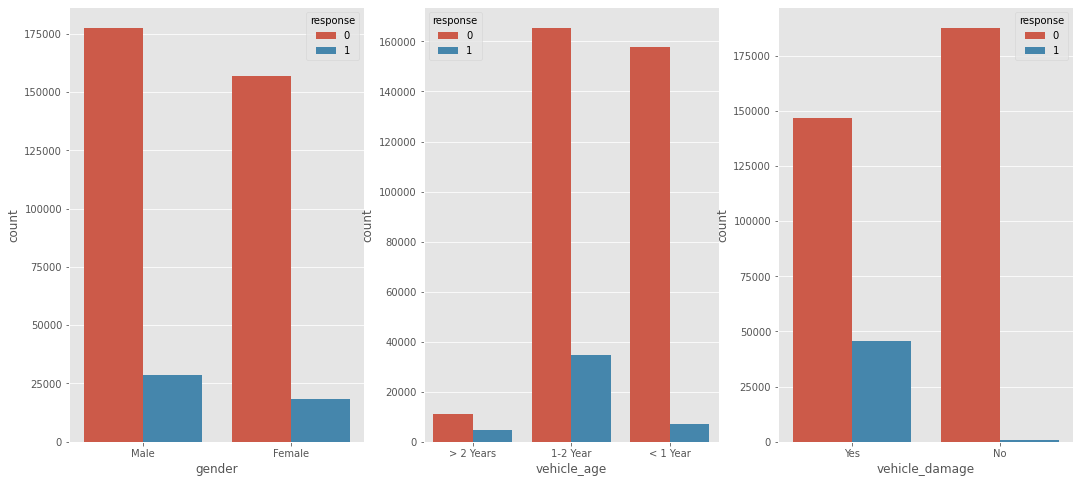

In [16]:
plt.subplot(1, 3, 1)
sns.countplot(x='gender', hue='response', data=df2)
plt.subplot(1, 3, 2)
sns.countplot(x='vehicle_age', hue='response', data=df2)
plt.subplot(1, 3, 3)
sns.countplot(x='vehicle_damage', hue='response', data=df2);

# 3 - Feature engineering

In [60]:
df3 = df2.copy()

## 3.1 - Mapa mental das hipóteses

## 3.2 - Criação das hipóteses

## 3.3 - Lista final das hipóteses

## 3.4 - Feature engineering

In [61]:
# Vehicle age
df3['vehicle_age'] = df3['vehicle_age'].apply(lambda x: 'menor_1_ano' if x == '< 1 Year' else 'entre_1-2_anos' if x == '1-2 Year' else 'maior_2_anos')

# Vehicle damage
df3['vehicle_damage'] = df3['vehicle_damage'].apply(lambda x: 0 if x == 'No' else 1)

# 4 - Filtragem das variáveis

In [64]:
df4 = df3.copy()

## 4.1 - Seleção das linhas

## 4.2 - Seleção das colunas

# 5 - Análise exploratória dos dados

In [65]:
df5 = df4.copy()

## 5.1 - Análise univariada

### Gender

In [66]:
df5[['gender', 'response']].value_counts().reset_index().rename(columns={0:'count'})

,gender,response,count
0,Male,0,177564
1,Female,0,156835
2,Male,1,28525
3,Female,1,18185


In [67]:
df5[['gender', 'response']].value_counts(normalize=True).reset_index().rename(columns={0:'percent'})

,gender,response,percent
0,Male,0,0.465914
1,Female,0,0.411523
2,Male,1,0.074847
3,Female,1,0.047716


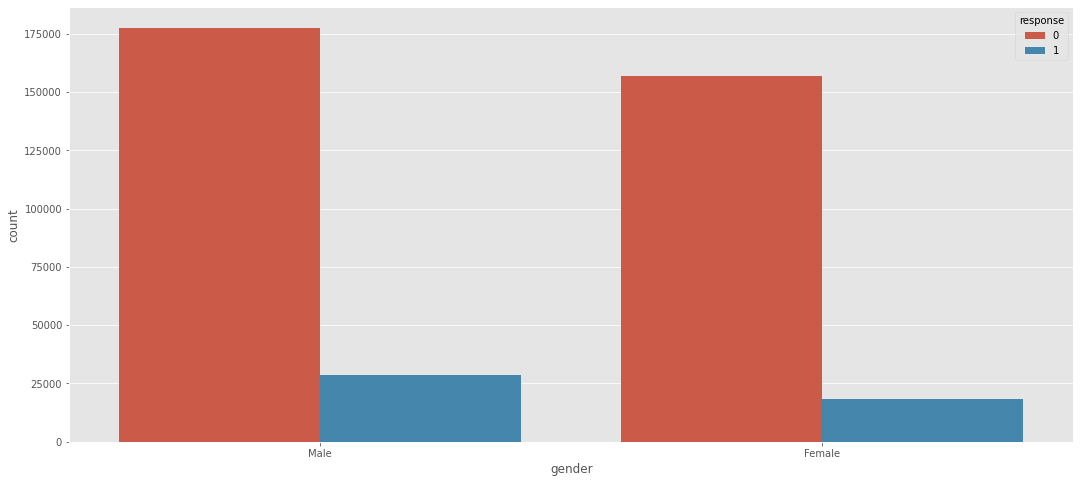

In [68]:
sns.countplot(x='gender', hue='response', data=df5);

### Age

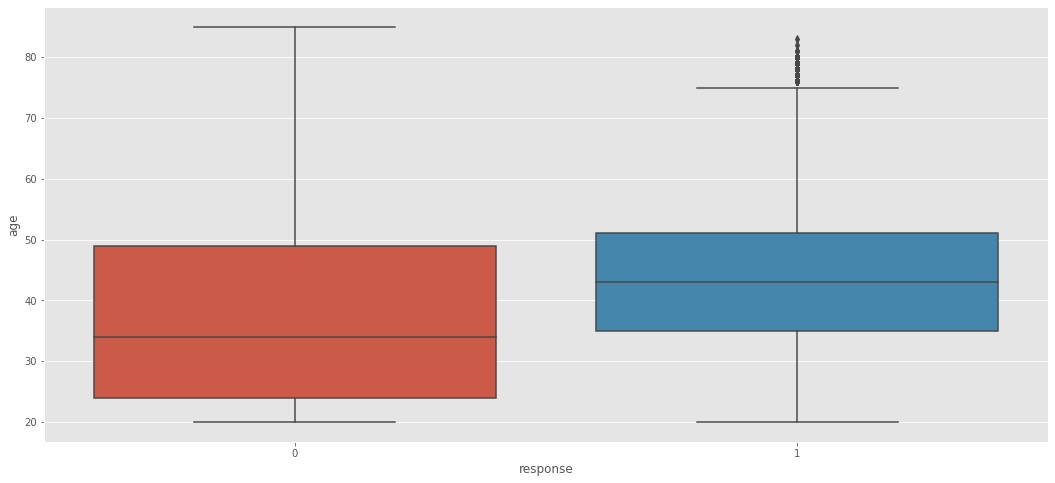

In [69]:
sns.boxplot(x='response', y='age', data=df5);

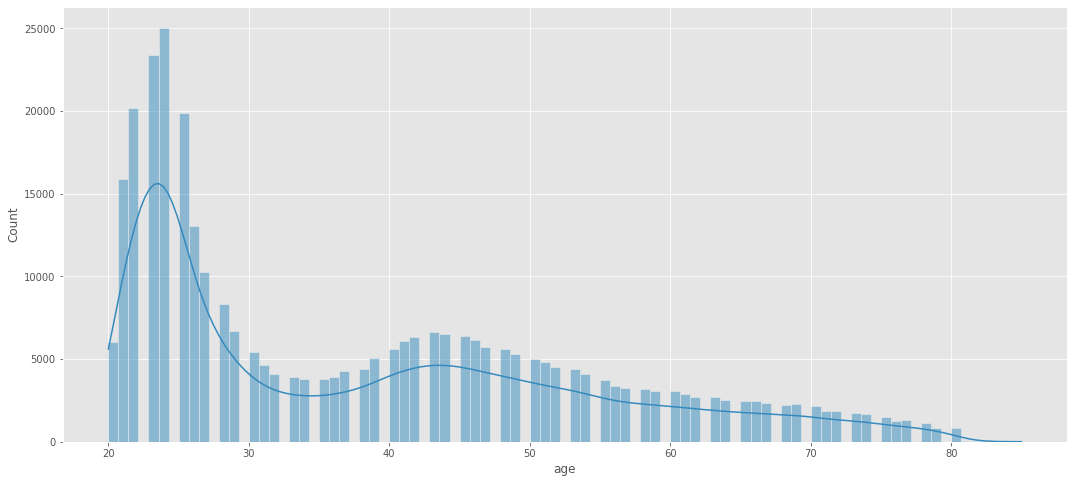

In [70]:
aux = df5.loc[df5['response'] == 0, 'age']
sns.histplot(data=aux, kde=True);

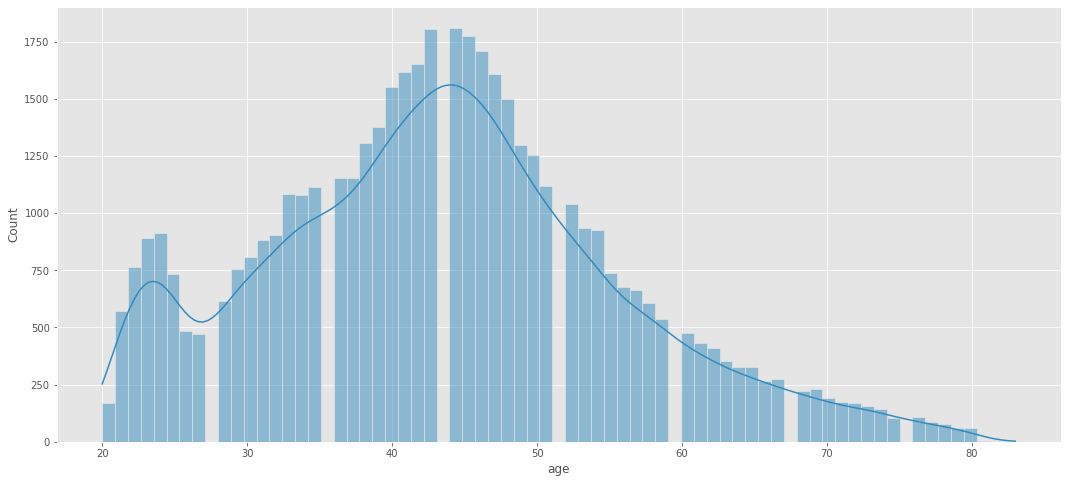

In [71]:
aux = df5.loc[df5['response'] == 1, 'age']
sns.histplot(data=aux, kde=True);

### Driving license

In [72]:
df5[['driving_license', 'response']].value_counts().reset_index().rename(columns={0:'count'})

,driving_license,response,count
0,1,0,333628
1,1,1,46669
2,0,0,771
3,0,1,41


In [73]:
df5[['driving_license', 'response']].value_counts(normalize=True).reset_index().rename(columns={0:'percent'})

,driving_license,response,percent
0,1,0,0.875414
1,1,1,0.122456
2,0,0,0.002023
3,0,1,0.000108


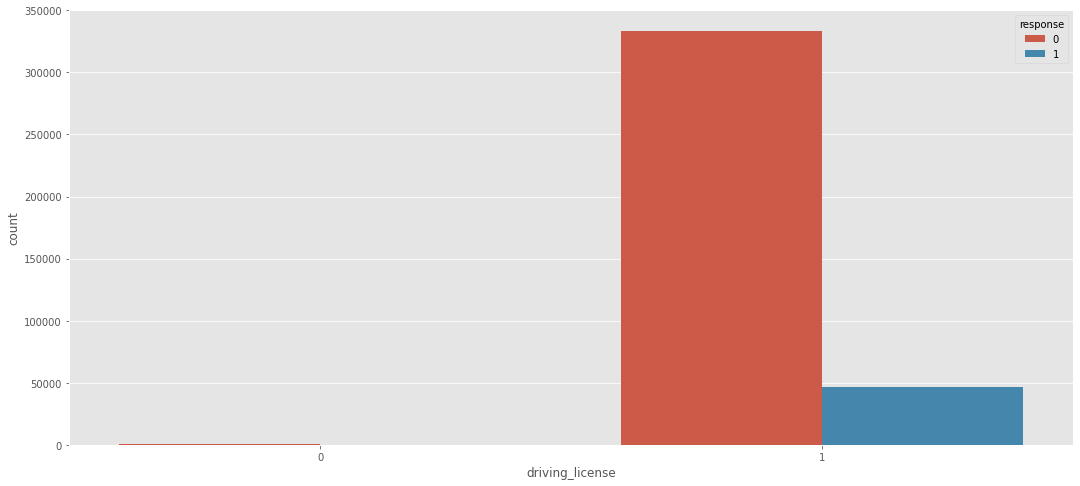

In [74]:
sns.countplot(x='driving_license', hue='response', data=df5);

### Region code

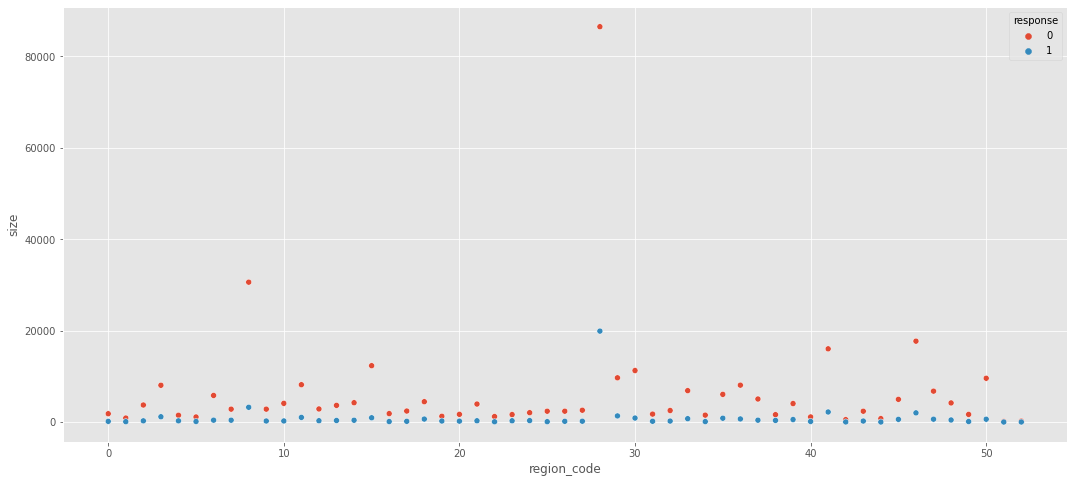

In [75]:
aux = df5.groupby(['region_code', 'response'], as_index=False)['region_code'].size()
sns.scatterplot(x='region_code', y='size', hue='response', data=aux);

### Previously insured

In [76]:
df5[['previously_insured', 'response']].value_counts().reset_index().rename(columns={0:'count'})

,previously_insured,response,count
0,1,0,174470
1,0,0,159929
2,0,1,46552
3,1,1,158


In [77]:
df5[['previously_insured', 'response']].value_counts(normalize=True).reset_index().rename(columns={0:'percent'})

,previously_insured,response,percent
0,1,0,0.457796
1,0,0,0.419641
2,0,1,0.122149
3,1,1,0.000415


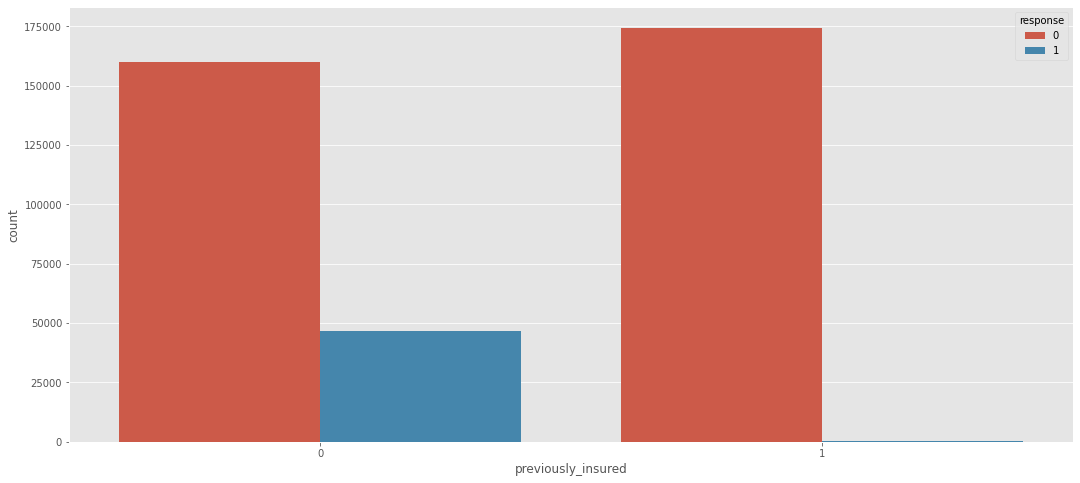

In [78]:
sns.countplot(x='previously_insured', hue='response', data=df5);

### Vehicle age

In [80]:
df5[['vehicle_age', 'response']].value_counts().reset_index().rename(columns={0:'count'})

,vehicle_age,response,count
0,entre_1-2_anos,0,165510
1,menor_1_ano,0,157584
2,entre_1-2_anos,1,34806
3,maior_2_anos,0,11305
4,menor_1_ano,1,7202
5,maior_2_anos,1,4702


In [81]:
df5[['vehicle_age', 'response']].value_counts(normalize=True).reset_index().rename(columns={0:'percent'})

,vehicle_age,response,percent
0,entre_1-2_anos,0,0.434285
1,menor_1_ano,0,0.413488
2,entre_1-2_anos,1,0.091328
3,maior_2_anos,0,0.029663
4,menor_1_ano,1,0.018897
5,maior_2_anos,1,0.012338


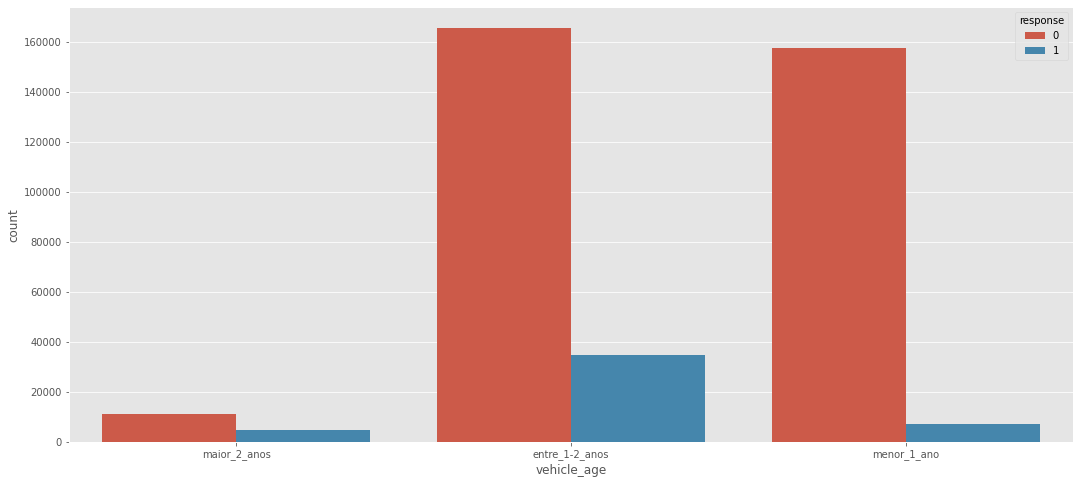

In [82]:
sns.countplot(x='vehicle_age', hue='response', data=df5);

### Vehicle_damage

In [90]:
df5[['vehicle_damage', 'response']].value_counts().reset_index().rename(columns={0:'count'})

,vehicle_damage,response,count
0,0,0,187714
1,1,0,146685
2,1,1,45728
3,0,1,982


In [91]:
df5[['vehicle_damage', 'response']].value_counts(normalize=True).reset_index().rename(columns={0:'percent'})

,vehicle_damage,response,percent
0,0,0,0.492547
1,1,0,0.384890
2,1,1,0.119987
3,0,1,0.002577


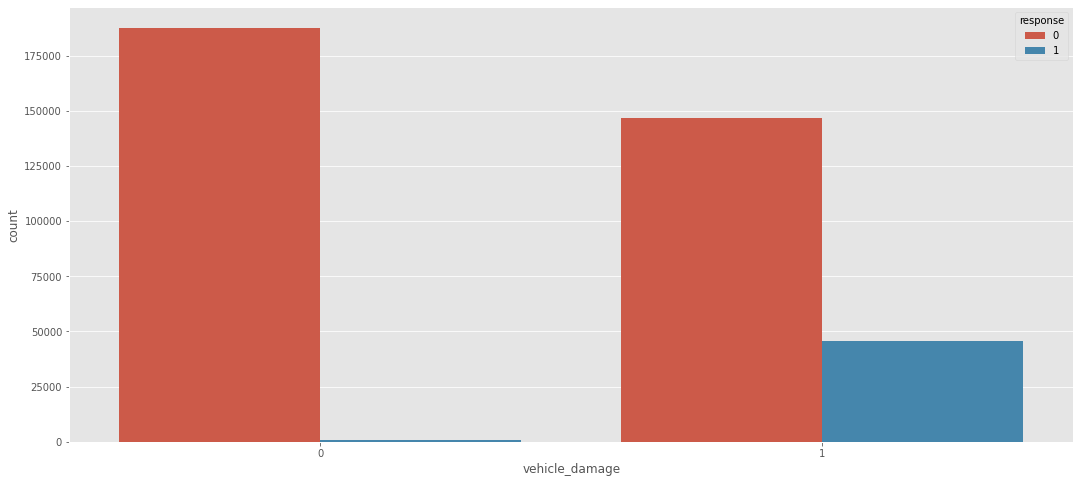

In [92]:
sns.countplot(x='vehicle_damage', hue='response', data=df5);

### Annual premium

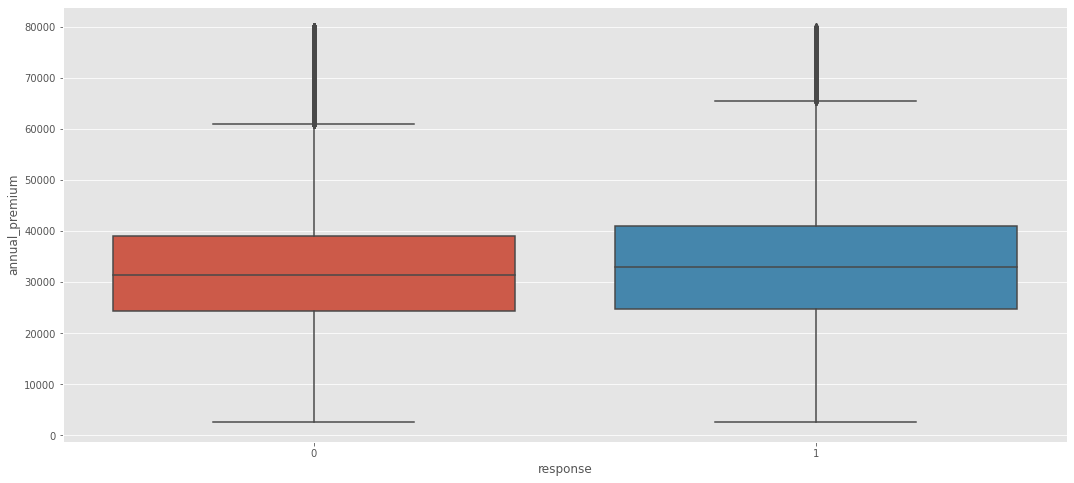

In [111]:
aux = df5[df5['annual_premium'] < 80000]
sns.boxplot(x='response', y='annual_premium', data=aux);

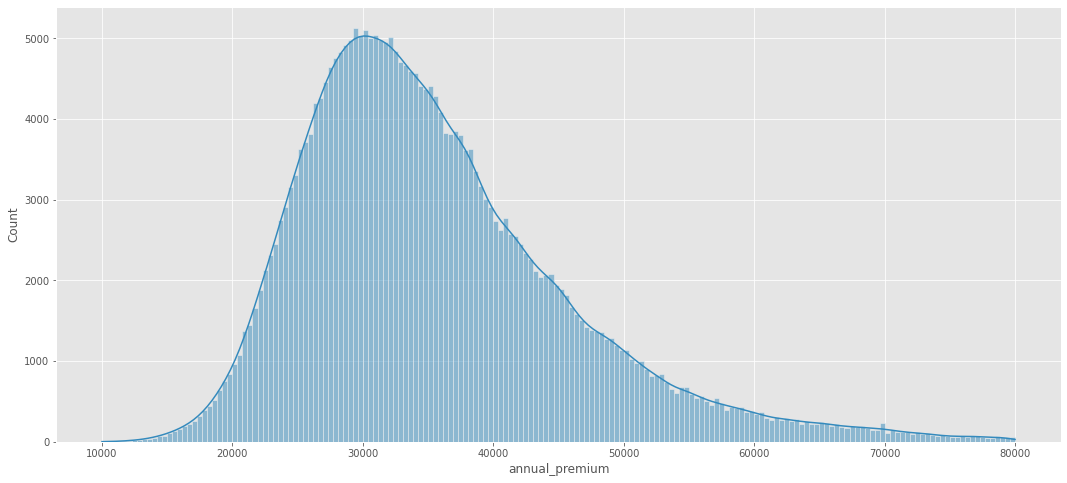

In [114]:
aux = df5[(df5['annual_premium'] > 10000) &(df5['annual_premium'] < 80000)]
aux = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(data=aux, kde=True);

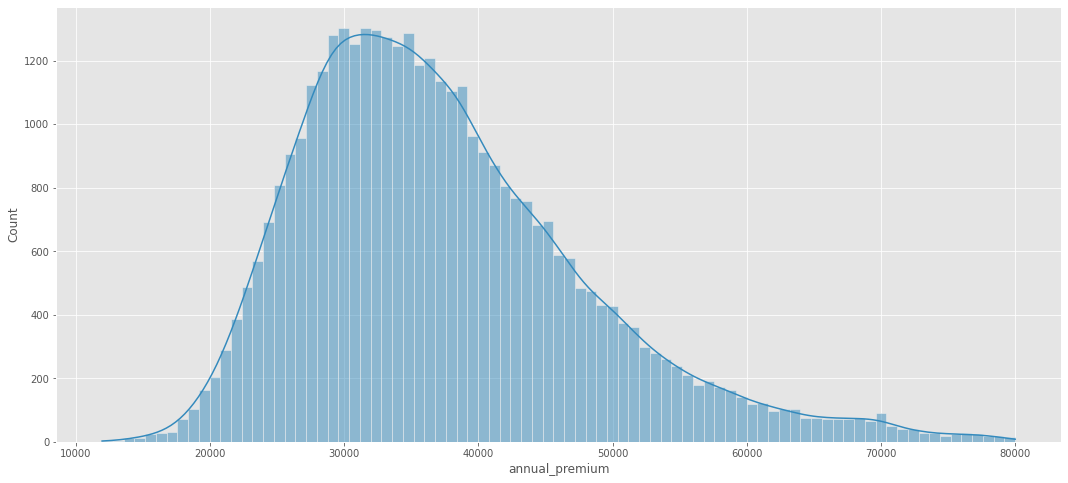

In [115]:
aux = df5[(df5['annual_premium'] > 10000) &(df5['annual_premium'] < 80000)]
aux = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(data=aux, kde=True);

### Policy sales channel

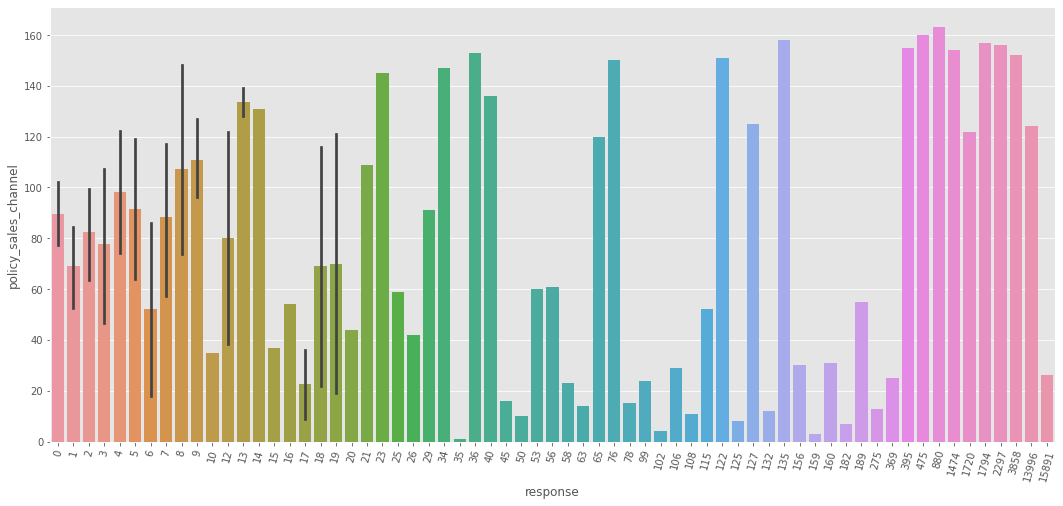

In [128]:
aux = df5[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel').sum().reset_index()
sns.barplot(x='response', y='policy_sales_channel', data=aux)
plt.xticks(rotation=75);

### Vintage

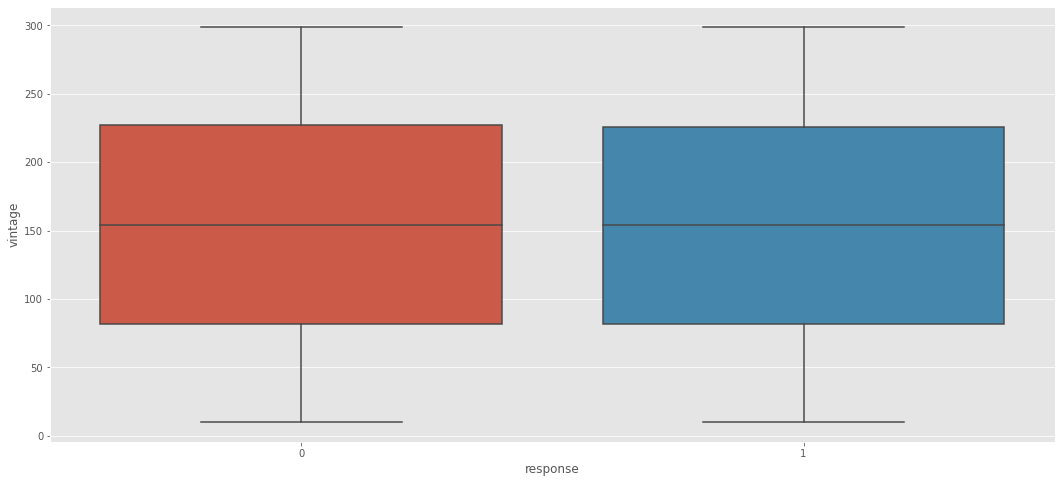

In [131]:
sns.boxplot(x='response', y='vintage', data=df5);

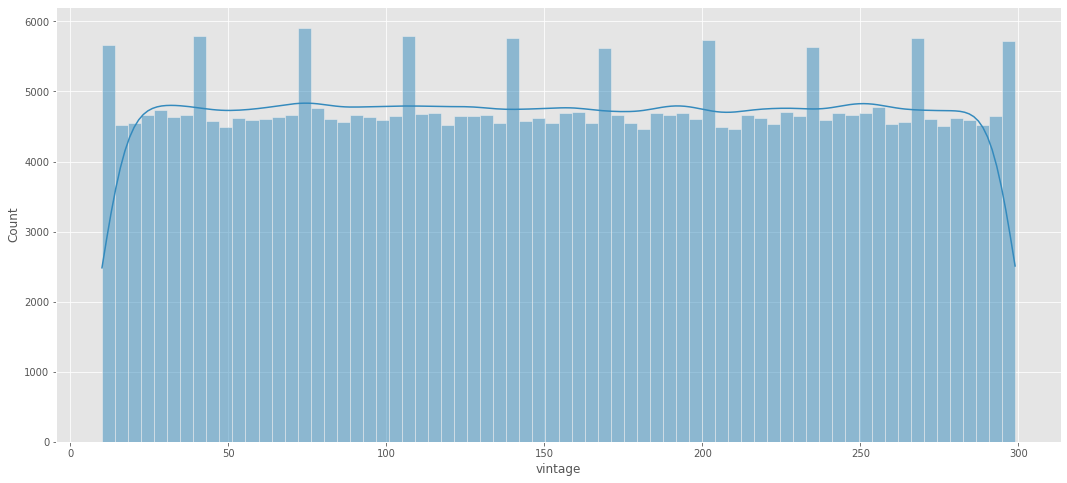

In [132]:
aux = df5.loc[df5['response'] == 0, 'vintage']
sns.histplot(data=aux, kde=True);

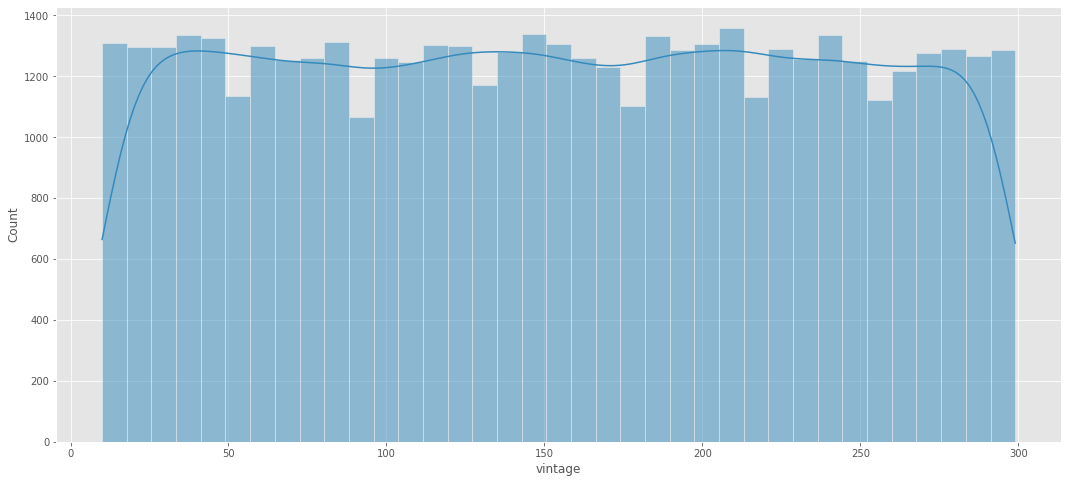

In [133]:
aux = df5.loc[df5['response'] == 1, 'vintage']
sns.histplot(data=aux, kde=True);

### Response

In [139]:
df5['response'].value_counts(normalize=True).reset_index().rename(columns={'response':'percent', 'index':'response'})

,response,percent
0,0,0.877437
1,1,0.122563


In [140]:
df5['response'].value_counts().reset_index().rename(columns={'response':'count', 'index':'response'})

,response,count
0,0,334399
1,1,46710


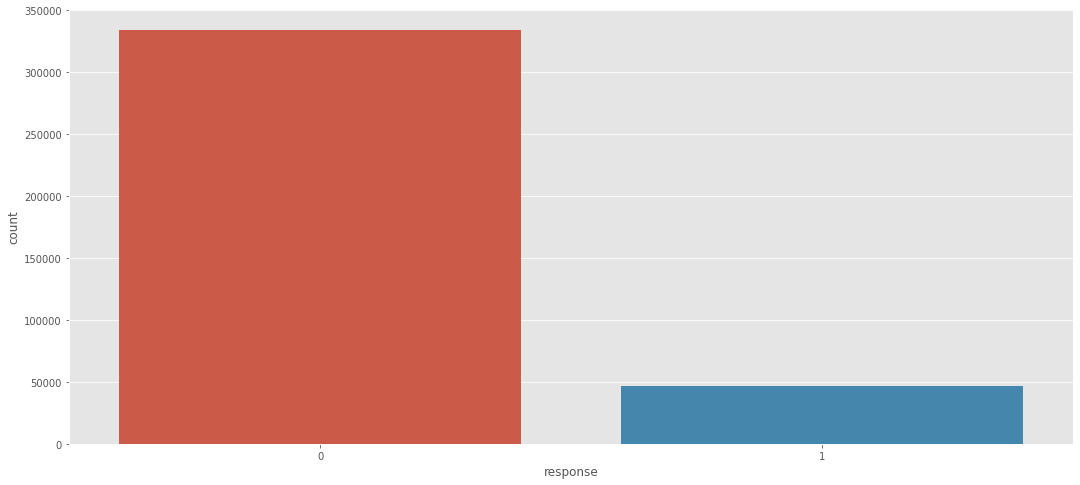

In [141]:
sns.countplot(x=df5['response']);

## 5.2 - Análise bivariada

In [85]:
# Validação das hipóteses

## 5.3 - Análise multivariada

### 5.3.1 - Análise numérica

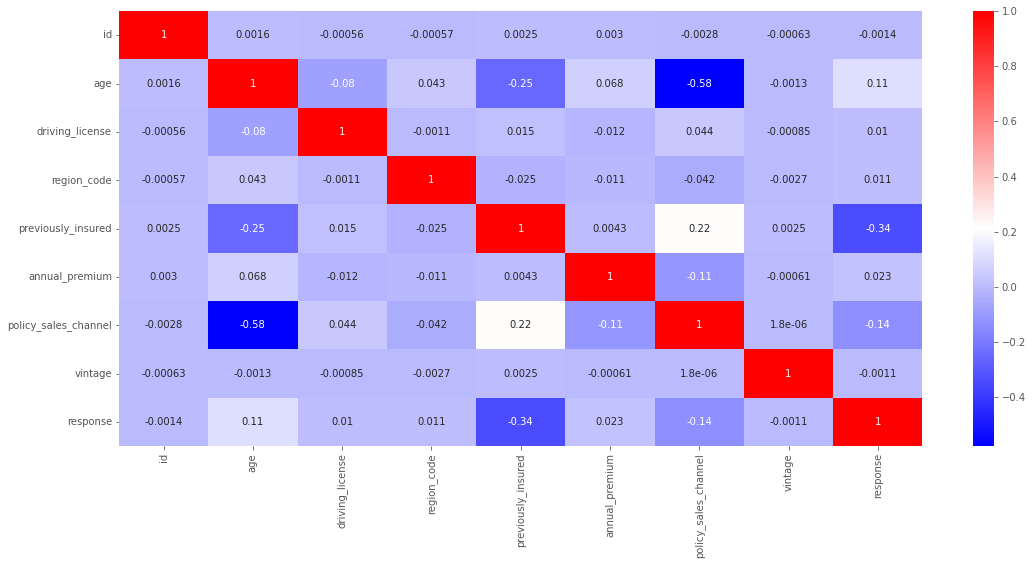

In [86]:
# Método de pearson
correlacao = num.corr()
sns.heatmap(correlacao, annot=True, cmap='bwr');

### 5.3.2 - Análise categórica

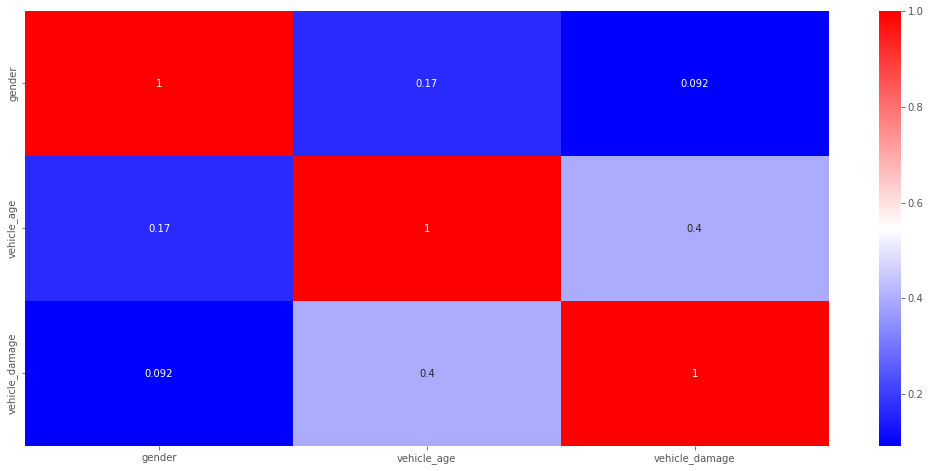

In [87]:
# Método de Cramer
correlacao = corr_matrix(cat, cat.columns)
sns.heatmap(correlacao, annot=True, cmap='bwr');

# 6 - Preparação dos dados

In [88]:
df6 = df5.copy()

## 6.1 - Separação do dataframe entre treino e teste

## 6.2 - Normalização

## 6.3 - Rescaling

## 6.4 - Transformação

### 6.4.1 - Encoding

### 6.4.2 - Transformação da variável resposta

### 6.4.3 - Transformação de natureza

# 7 - Seleção de features

## 7.1 - Excluir colunas para a seleção

## 7.2 - Seleção de features com o Boruta

## 7.3 - Seleção manual das features

## 8 - Modelos de Machine Learning

## 8.1 - Modelo de baseline

In [36]:
# média para o caso de regressão e aleatório para classificação

## 8.x - Escolher outros modelos

# 9 - Fine Tunning

## 9.1 - Busca aleatória

In [37]:
# RandomizedSearch ou GridSearch (sklearn model_selection)
# BayesSearch (skopt BayesSearchCV, no site https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html#skopt.BayesSearchCV) 

## 9.2 - Modelo final

# 10 - Tradução e interpretação do erro

## 10.1 - Business Perfomance

## 10.2 - Total Perfomance

## 10.3 - Machine Learning Perfomance